# Frequentist Inference Case Study - Part B


*Quick note to Springboard grader:*

This notebook was submitted before. It is in the same folder as the `Case Study A` counterpart.<br>
Both Chap `11.13` and `11.14` states to complete part A & part B in its instructions which are identical, on my view of the curriculum:I am part of the May'23 cohort.<br>
Resubmitting for completion! Thanks!


## Learning objectives


Welcome to Part B of the Frequentist inference case study! The purpose of this case study is to help you apply the concepts associated with Frequentist inference in Python. In particular, you'll practice writing Python code to apply the following statistical concepts:

- the _z_-statistic
- the _t_-statistic
- the difference and relationship between the two
- the Central Limit Theorem, including its assumptions and consequences
- how to estimate the population mean and standard deviation from a sample
- the concept of a sampling distribution of a test statistic, particularly for the mean
- how to combine these concepts to calculate a confidence interval


In the previous notebook, we used only data from a known normal distribution. **You'll now tackle real data, rather than simulated data, and answer some relevant real-world business problems using the data.**


## Hospital medical charges


Imagine that a hospital has hired you as their data scientist. An administrator is working on the hospital's business operations plan and needs you to help them answer some business questions.

In this assignment notebook, you're going to use frequentist statistical inference on a data sample to answer the questions:

- has the hospital's revenue stream fallen below a key threshold?
- are patients with insurance really charged different amounts than those without?

Answering that last question with a frequentist approach makes some assumptions, and requires some knowledge, about the two groups.


We are going to use some data on medical charges obtained from [Kaggle](https://www.kaggle.com/easonlai/sample-insurance-claim-prediction-dataset).

For the purposes of this exercise, assume the observations are the result of random sampling from our single hospital. Recall that in the previous assignment, we introduced the Central Limit Theorem (CLT), and its consequence that the distributions of sample statistics approach a normal distribution as $n$ increases. The amazing thing about this is that it applies to the sampling distributions of statistics that have been calculated from even highly non-normal distributions of data! Recall, also, that hypothesis testing is very much based on making inferences about such sample statistics. You're going to rely heavily on the CLT to apply frequentist (parametric) tests to answer the questions in this notebook.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.stats import ttest_ind
from numpy.random import seed
from pathlib import Path
from numba import njit

In [2]:
plt.rcParams["axes.labelcolor"] = "#424242"
plt.rcParams["axes.titlecolor"] = "#424242"
plt.rcParams["xtick.labelcolor"] = "#424242"
plt.rcParams["ytick.labelcolor"] = "#424242"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.titlepad"] = 10

In [3]:
insurance_path = Path("../data/insurance2.csv")

In [4]:
medical = pd.read_csv("../../data/insurance2.csv")

In [5]:
medical.shape

(1338, 8)

In [6]:
medical.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


**Q1:** Plot the histogram of charges and calculate the mean and standard deviation. Comment on the appropriateness of these statistics for the data.


**A:**


Mean of charges: $13,270.42
Standard deviation of charges: $12,110.01


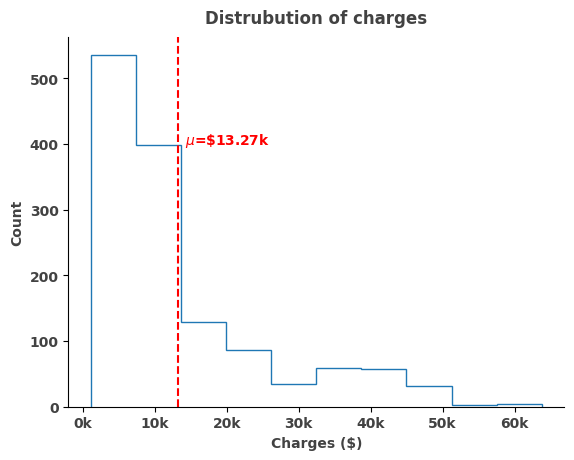

In [7]:
charges_mean = np.mean(medical["charges"])
charges_std = np.std(medical["charges"], ddof=1)
print(f"Mean of charges: ${charges_mean:,.2f}")
print(f"Standard deviation of charges: ${charges_std:,.2f}")

fig, ax = plt.subplots()
plt.hist(
    medical["charges"] / 1000,
    histtype="step",
)
ax.xaxis.set_major_formatter("{x:,.0f}k")
plt.xlabel("Charges ($)")
plt.ylabel("Count")
plt.title("Distrubution of charges")

plt.axvline(x=charges_mean / 1000, color="r",
            linestyle="--", label="mean charge")
plt.annotate(
    text=f"$\mu$=\${charges_mean/1000:.2f}k",
    xy=(charges_mean / 1000 + 1, 400),
    color="r",
)
# plt.legend()
plt.show()

The standard deviation and mean is more useful in finding proportions of the data when the data is normally distributed. As the shape of this data does not resemble a normal curve, they are less useful.


**Q2:** The administrator is concerned that the actual average charge has fallen below 12,000, threatening the hospital's operational model. On the assumption that these data represent a random sample of charges, how would you justify that these data allow you to answer that question? And what would be the most appropriate frequentist test, of the ones discussed so far, to apply?


**A:**
Given that the data is a random sample, it should be an approximate of the true population data.<br>

An appropriate test would be the *null hypothesis significance test* from which we would obtain a *p-value*. We can then answer this question with the technique of _bootstrapping_, to get the bootstrap estimate of the mean. If we repeat the measurement over and over again, p% of the observed values would lie within p% confidence interval. We take the percentiles of the bootstrap replicates to compute the confidence interval.


**Q3:** Given the nature of the administrator's concern, what is the appropriate confidence interval in this case? A **_one-sided_** or **_two-sided_** interval? (Refresh your understanding of this concept on p. 399 of the _AoS_). Calculate the critical value and the relevant 95% confidence interval for the mean, and comment on whether the administrator should be concerned.


**A:**


In [8]:
print(f"One-sided interval is the appropriate confidence interval.")

One-sided interval is the appropriate confidence interval.


**Null hypothesis**: The actual average charge per record is below 12,000.<br>
**Alternative hypothesis**: The actual average charge per record is above 12,000.<br>
**Test statistic**: the mean charge per record.<br>
**At least as extreme as**: the average charge is greater than 12,000.<br>

In [9]:
# sample_size = len(medical)
medical_charges = medical.charges.values
mean_charge_hyp = 12000

In [10]:
@njit
def bs_replicate(data):
    n = len(data)
    sample = np.random.choice(data, size=n)
    return np.mean(sample)


@njit
def draw_replicates(data, size):
    reps = np.empty(size, dtype=np.float64)
    for i in range(size):
        reps[i] = bs_replicate(data)
    return reps

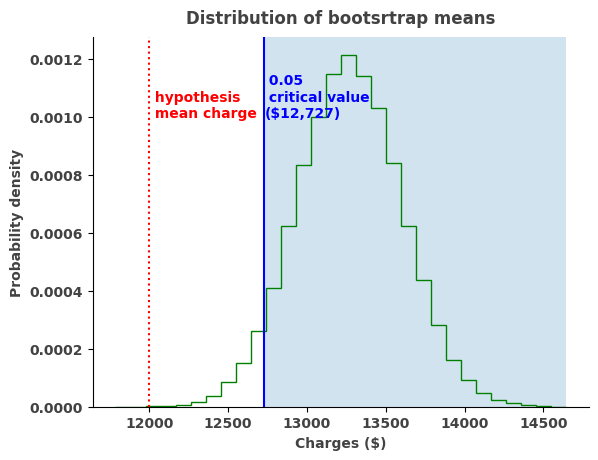

In [11]:
reps = 100_000
sample_means = draw_replicates(medical_charges, reps)
std_error = np.std(sample_means, ddof=1)
ci = np.percentile(sample_means, [5, 100])

plt.hist(sample_means, bins=30, histtype="step", density=True, color='g')
plt.axvspan(xmin=ci[0], xmax=ci[1], alpha=0.2)
plt.axvline(x=12000, linestyle=':', color='r', label='hypothesis mean charge')
plt.axvline(x=ci[0], linestyle='-', color='b', label='significance level (5%)')
plt.annotate(text=f' 0.05\n critical value\n(${ci[0]:,.0f})', xy=(
    ci[0]+3, 0.001), color='b')
plt.annotate(text=' hypothesis\n mean charge', xy=(12000+3, 0.001), color='r')
plt.xlabel("Charges ($)")
plt.ylabel("Probability density")
plt.title('Distribution of bootsrtrap means')
# plt.legend()
plt.show()

In [12]:
print(f"95% confidence inteval (0.05, 1.00): {ci}")

# Number of standard errors 12,000 is away form mean
sample_means_mean = np.mean(sample_means)
n_sd = (sample_means_mean - mean_charge_hyp) / std_error
print(f"$12,000 is {n_sd:.2f} standard errors away for the mean. ")

# Critical value
critical_value = ci[0]
print(f"Critical value: {critical_value:.0f}")

# p-value
p_value = np.sum(sample_means < 12000) / reps

print(f"p-value: {p_value}")
if p_value < 0.05:
    print("Reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

95% confidence inteval (0.05, 1.00): [12727.44667745 14645.90256417]
$12,000 is 3.83 standard errors away for the mean. 
Critical value: 12727
p-value: 5e-05
Reject the null hypothesis.


The administrator then wants to know whether people with insurance really are charged a different amount to those without.

**Q4:** State the null and alternative hypothesis here. Use the _t_-test for the difference between means, where the pooled standard deviation of the two groups is given by:
\begin{equation}
s_p = \sqrt{\frac{(n_0 - 1)s^2_0 + (n_1 - 1)s^2_1}{n_0 + n_1 - 2}}
\end{equation}

and the _t_-test statistic is then given by:

\begin{equation}
t = \frac{\bar{x}_0 - \bar{x}_1}{s_p \sqrt{1/n_0 + 1/n_1}}.
\end{equation}

(If you need some reminding of the general definition of **_t-statistic_**, check out the definition on p. 404 of _AoS_).

What assumption about the variances of the two groups are we making here?


**A:**


**Null hypothesis**: there is no difference between the mean charge for people with insurance and the mean charge for people without insurance.<br>
**Alternative hypothesis**: the difference in the means of the distributions underlying the samples is different from 0.<br>
**Test statistic**: the difference in mean charges between people with insurance and people without insurance<br>
**At least as extreme as**: the difference in the mean is nonzero


We are making the assumption that the populations has identical variances, and that they are 2 independent samples.

**Q5:** Perform this hypothesis test both manually, using the above formulae, and then using the appropriate function from [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#statistical-tests) (hint, you're looking for a function to perform a _t_-test on two independent samples). For the manual approach, calculate the value of the test statistic and then its probability (the p-value). Verify you get the same results from both.


**A:**


In [13]:
medical_yes_ins = medical[medical['insuranceclaim'] == 1]
medical_no_ins = medical[medical['insuranceclaim'] == 0]

# medical charges
yes_ins_charges = medical_yes_ins.charges.values
no_ins_charges = medical_no_ins.charges.values

# means
xbar_yes = medical_yes_ins.charges.mean()
xbar_no = medical_no_ins.charges.mean()

n_yes = len(medical_yes_ins)
n_no = len(medical_no_ins)

# std dev
s_yes = np.std(yes_ins_charges, ddof=1)
s_no = np.std(no_ins_charges, ddof=1)

# pooled standard deviation
s_p = np.sqrt(((n_yes - 1) * s_yes**2 + (n_no - 1)
              * s_no**2) / (n_yes + n_no - 2))

# t-statistic
t_stat = (xbar_yes - xbar_no) / (s_p*np.sqrt(1/n_yes + 1/n_no))

# print(statistic)
# print(p_value)
print()
print(f"t-statistics: {t_stat}")
p_val = (1 - t.cdf(t_stat, df=n_yes + n_no - 2))/2
print(f"p_value: {p_val}")
if p_value < 0.05:
    print("Reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")


t-statistics: 11.89329903087671
p_value: 0.0
Reject the null hypothesis.


In [14]:
# independent 2-sample t-test
t_statistics, p_value = ttest_ind(
    yes_ins_charges,
    no_ins_charges,
    alternative="two-sided",
    permutations=10000,
)
print(f"t-statistic: {t_statistics}")
print(f"p-value: {p_value}")

t-statistic: 11.893299030876712
p-value: 9.999000099990002e-05


Congratulations! Hopefully you got the exact same numerical results. This shows that you correctly calculated the numbers by hand. Secondly, you used the correct function and saw that it's much easier to use. All you need to do is pass your data to it.


**Q6:** Conceptual question: look through the documentation for statistical test functions in scipy.stats. You'll see the above _t_-test for a sample, but can you see an equivalent one for performing a _z_-test from a sample? Comment on your answer.


**A:**
you can perform a 2-sample z-test with the `statsmodels` library using `statsmodels.stats.weightstats.ztest`

## Learning outcomes


Having completed this project notebook, you now have good hands-on experience:

- using the central limit theorem to help you apply frequentist techniques to answer questions that pertain to very non-normally distributed data from the real world
- performing inference using such data to answer business questions
- forming a hypothesis and framing the null and alternative hypotheses
- testing this using a _t_-test
